In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
 palette = ["#E31A1C", "#1F78B4", "#A6CEE3",  "#B2DF8A", "#33A02C", "#FB9A99",  "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", "#66C2A5",
               "#FC8D62", "#8DA0CB", "#B3B3B3", "#A6D854", "#FFD92F", "#E5C494", "#E78AC3"]

#### Set up scVI environment

In [3]:
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
import pandas as pd 
import numpy as np

# MALE

### Read in dataset

In [5]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [6]:
adata = sc.read(path_to_gonads + 'mouse-gonads_rawcounts.h5ad')

In [7]:
adata = adata[[i in 'male' for i in adata.obs.sex]]
adata.X.shape

(33017, 24482)

In [47]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse_males_scVIintegrated_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['lineage'].to_dict()
adata.obs['lineage_previous'] = adata.obs_names.map(cell_annot).astype('category')

In [9]:
sc.pp.filter_genes(adata, min_counts=3)

### OPTIONAL - Remove cc genes

In [10]:
# ccgs defined in M1
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes after ccg filter: 23713


### Identify HVGs

!!! Unlike before (at least I think), now they recommend subsetting to highly variable genes before running scVI 

--> the tutorial says anywhere in between 1000 and 10,000 should be fine, so I arbitrarily chose 2000

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3",
    batch_key="stage"
)

/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
Trying to set attribute `.uns` of view, copying.


In [12]:
# subset object for scVI
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

## Normalize - optional

In [13]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

## scVI

!!! Here you can specify your covariates you want to correct for

In [14]:
scvi.data.setup_anndata(
    bdata,
    layer="counts",
    batch_key='stage'
#     categorical_covariate_keys=["stage"] #,
#     continuous_covariate_keys=["percent_mito"]#
)

INFO     Using batches from adata.obs["stage"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 33017 cells, 2000 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [15]:
model = scvi.model.SCVI(bdata, n_latent= 20)

In [16]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 20, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [17]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 242/242: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [3:02:44<00:00, 45.31s/it, loss=850, v_num=1]


In [18]:
latent = model.get_latent_representation()

In [19]:
adata.obsm["X_scVI"] = latent

### Save latent space

In [20]:
pd.DataFrame(adata.obsm["X_scVI"]).to_csv(path_to_gonads+'/mouse-gonads_XscVI_latent_male.csv')
adata.obs.to_csv(path_to_gonads+'/mouse-gonads_XscVI_obs_male.csv')

### Visualization and Clustering

In [21]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.4)

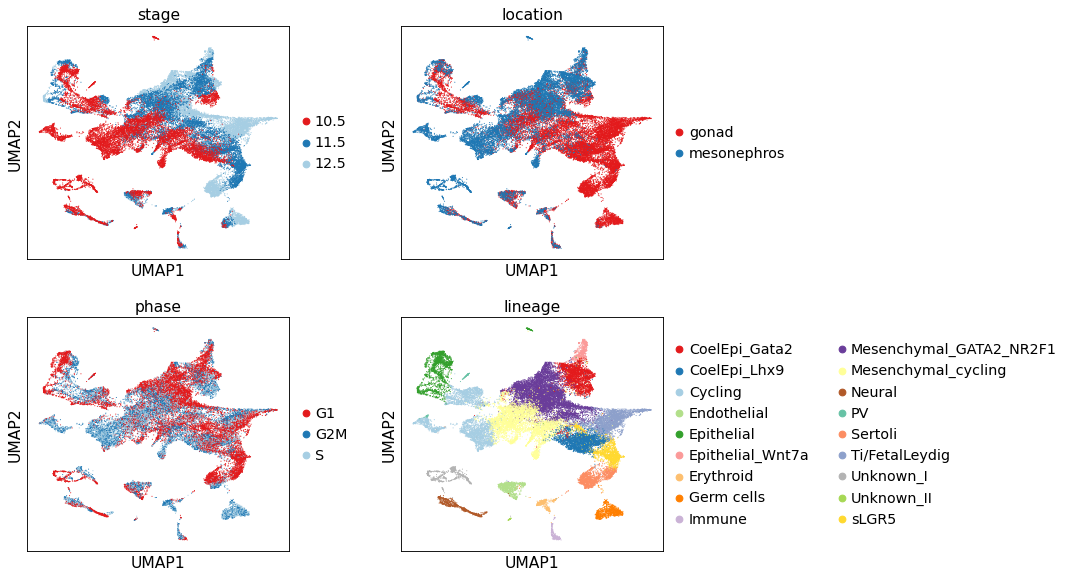

In [22]:
sc.pl.umap(
    adata,
    color=[ "stage", 'location', "phase", 'lineage'], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.3
)

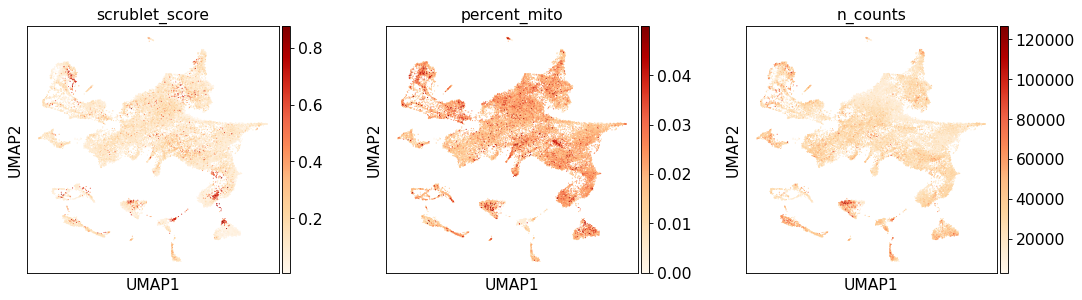

In [23]:
sc.pl.umap(
    adata,
    color=['scrublet_score',  'percent_mito', 'n_counts'], color_map = "OrRd",
    frameon=True, ncols = 3, wspace = 0.3
)